# Rejection sampling

We have an unnormalized density $f(x)$ and we have a density $g(x)$ which is easy to sample from. How do we sample from $f(x)$?

In [1]:
import jax
import jax.numpy as jnp

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt
import arviz as az

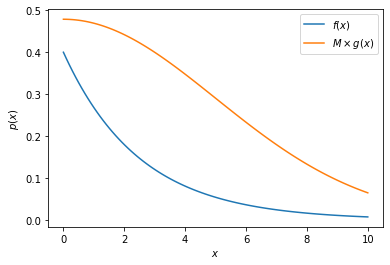

In [2]:
x_range = jnp.linspace(0, 10, 100)  # restricting to 10

f_x = tfd.Exponential(rate=0.4, force_probs_to_zero_outside_support=True)
g_x = tfd.Normal(loc=0, scale=5)
M = 6

plt.plot(x_range, f_x.prob(x_range), label='$f(x)$');
plt.plot(x_range, M * g_x.prob(x_range), label=r'$M \times g(x)$');
 
plt.xlabel('$x$')
plt.ylabel('$p(x)$');
plt.legend();

In [3]:
f_x.prob(-1.0)

DeviceArray(0., dtype=float32)

In [4]:
def get_sample(seed):
    sample = g_x.sample(seed=seed)
    upper_limit = M * g_x.prob(sample)
#     print(f"sample={sample}, Mg(x)={upper_limit}, f(x)={f_x.prob(sample)}")
    uniform = tfd.Uniform(low=0, high=upper_limit)
    seed = jax.random.split(seed, num=1)[0]
    uni_x = uniform.sample(seed=seed)
    seed = jax.random.split(seed, num=1)[0]
    condition = uni_x < f_x.prob(sample)
    return condition, sample

In [5]:
num_samples = 10000
seed = jax.random.PRNGKey(0)
seeds = jax.random.split(seed, num=num_samples)

conditions, samples = jax.jit(jax.vmap(lambda seed: get_sample(seed)))(seeds)


accepted_samples = samples[conditions]

print(f'Total samples: {len(samples)}')
print(f"Accepted samples: {len(accepted_samples)}")
print(f"Ratio: {len(accepted_samples)/len(samples)}")

Total samples: 10000
Accepted samples: 1660
Ratio: 0.166


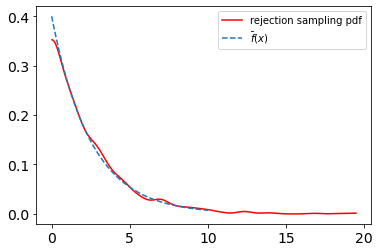

In [6]:
az.plot_dist(accepted_samples, label='rejection sampling pdf', color='red');
plt.plot(x_range, f_x.prob(x_range), '--', label=r'$\bar{f}(x)$');
plt.legend();

## Coin toss sampling

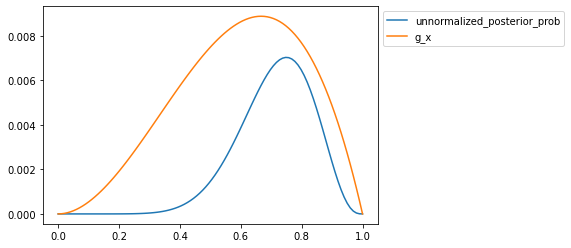

In [7]:
alpha = 2.0
beta = 2.0

prior = tfd.Beta(concentration0=alpha, concentration1=beta)
data = jnp.array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0])

def likelihood_fn(theta):
    likelihood = tfd.Bernoulli(probs=theta)
    return likelihood

class f_x:
    @staticmethod
    def prob(sample):
        prior_prob = prior.prob(sample)
        likelihood_prob = likelihood_fn(sample).prob(data).prod()
        return prior_prob * likelihood_prob

x_range = jnp.linspace(0, 1, 100)
unnormalized_posterior_prob = jax.vmap(f_x.prob)(x_range)

g_x = tfd.Beta(concentration0=2.0, concentration1=3.0)
M = 0.005

plt.plot(x_range, unnormalized_posterior_prob, label='unnormalized_posterior_prob');
plt.plot(x_range, M*g_x.prob(x_range), label='g_x');
plt.legend(bbox_to_anchor=(1,1));

In [8]:
num_samples = 10000
seed = jax.random.PRNGKey(0)
seeds = jax.random.split(seed, num=num_samples)

conditions, samples = jax.jit(jax.vmap(lambda seed: get_sample(seed)))(seeds)

accepted_samples = samples[conditions]

print(f'Total samples: {len(samples)}')
print(f"Accepted samples: {len(accepted_samples)}")
print(f"Ratio: {len(accepted_samples)/len(samples)}")

Total samples: 10000
Accepted samples: 4176
Ratio: 0.4176


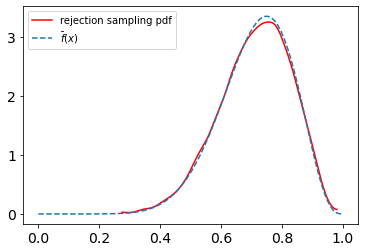

In [9]:
real_posterior = tfd.Beta(concentration0=alpha+(len(data) - data.sum()), concentration1=beta+data.sum())

az.plot_dist(accepted_samples, label='rejection sampling pdf', color='red');
plt.plot(x_range, real_posterior.prob(x_range), '--', label=r'$\bar{f}(x)$');
plt.legend();